In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding?

### Code for data generation

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Neuro_Analysis/population-methods/01-bayes-decoding/code"))
from utils import download_data

from scipy.stats import poisson
from tqdm import tqdm

import pickle
import seaborn as sns

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [ ]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [ ]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [ ]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [16]:

#download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/gOwG6DKD7IpkPze')

In [ ]:


file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

##a)

In [ ]:
# code decoding


# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan


100%|██████████| 5123/5123 [00:18<00:00, 275.61it/s]


In [ ]:
def sample_lists(true_x, x_decoded, n):

    indices = np.arange(len(true_x))
    sampled_indices = np.random.choice(indices, size=n, replace=False)

    sampled_true_x = [true_x[i] for i in sampled_indices]
    sampled_x_decoded = [x_decoded[i] for i in sampled_indices]

    return np.array(sampled_true_x), np.array(sampled_x_decoded)

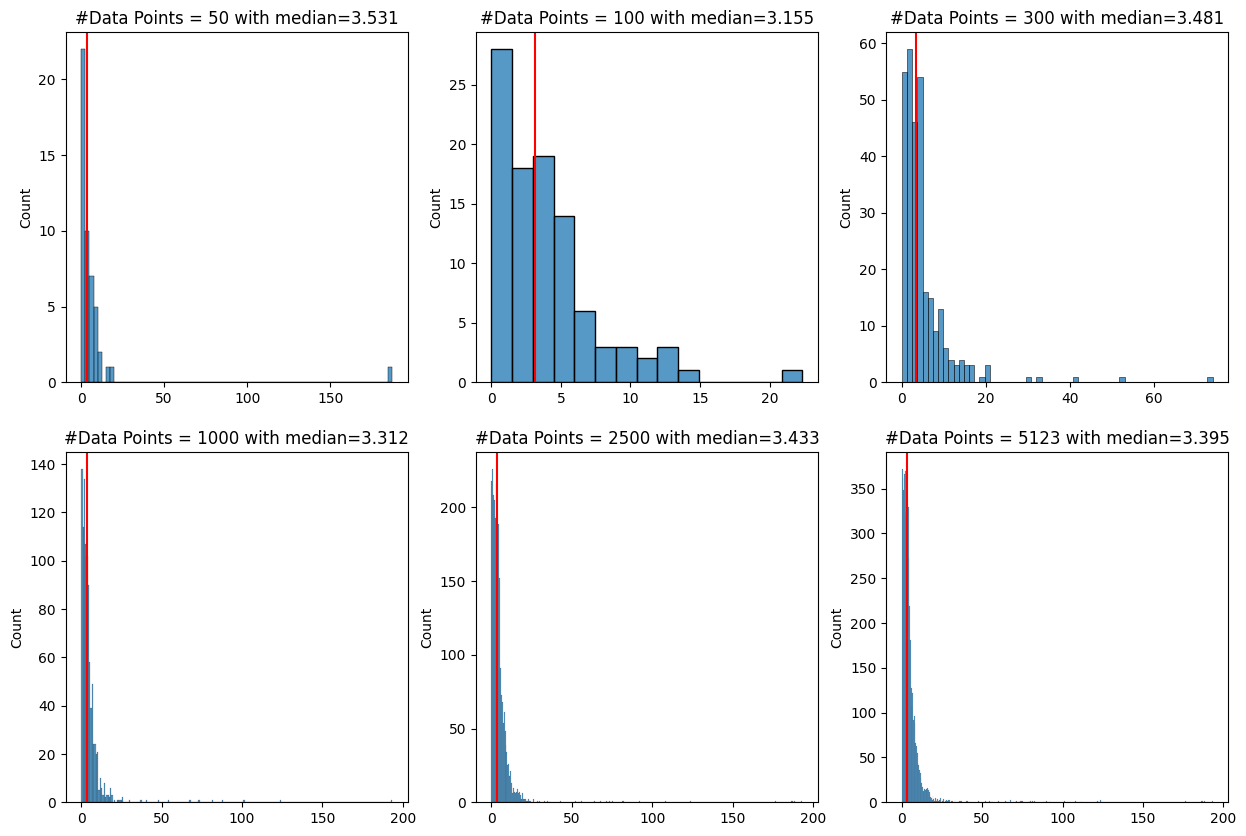

In [ ]:

fig, ax = plt.subplots(2,3, figsize = (15, 10))
nrData = [50, 100, 300, 1000, 2500, len(true_x)]
for i in range(6):
  sampled_true_x, sampled_x_decoded = sample_lists(true_x, x_decoded, n = nrData[i])
  mse = np.sqrt((sampled_true_x-sampled_x_decoded)**2)
  sns.histplot(mse, ax=ax[int(i >= 3), i % 3])
  ax[int(i>=3), i%3].axvline(x = np.nanmedian(mse),c='r')
  ax[int(i>=3), i%3].set_title("#Data Points = {nrdata} with median={mse}".format(nrdata = nrData[i], mse = np.round(np.nanmedian(mse), 3)))

Text(0.5, 1.0, 'Median Error as function of Samples')

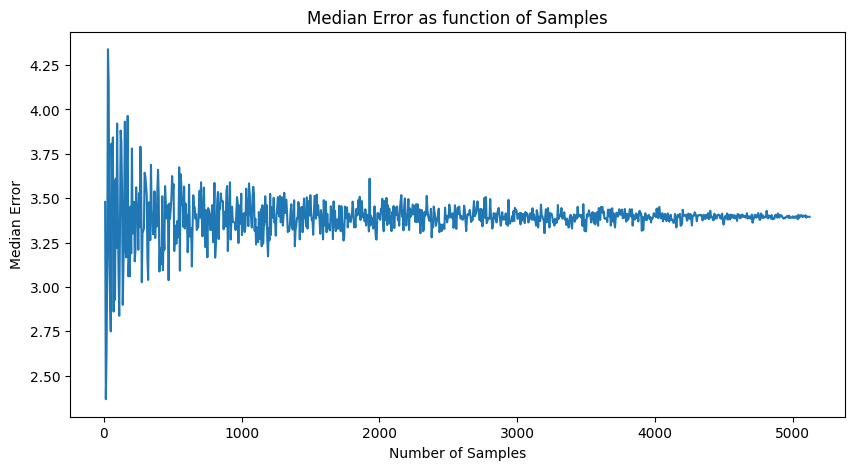

In [ ]:

nrData = np.linspace(10, len(true_x), 1000)
mse_list = []
for i in range(len(nrData)):
  sampled_true_x, sampled_x_decoded = sample_lists(true_x, x_decoded, n = int(nrData[i]))
  mse = np.sqrt((sampled_true_x-sampled_x_decoded)**2)
  mse_list.append(np.nanmedian(mse))
plt.plot(nrData, mse_list)
plt.xlabel("Number of Samples")
plt.ylabel("Median Error")
plt.title("Median Error as function of Samples")

The plot shows that the median error fluctuates widely with small sample sizes but stabilizes as the number of samples increases. Around 1000 samples, the error begins to stabilize, and beyond 3000 samples, additional data provides minimal improvement.

##b)


In [ ]:
def decode_position(n_cells, spikes, true_firing_rate_maps, fps, true_x, t):
    # Compute histograms for each cell
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)  # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps
    occupancy = np.histogram(x, space_bins)[0] / fps

    firing_rate_maps = spikes_hist / occupancy

    spikes_count = [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T  # we transpose the matrix to have the more familiar (samples x features) shape

    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin, :n_cells]) > 0:  # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin, :n_cells], firing_rate_maps[:n_cells, i] / fps) + pow(1, -15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan

    return x_decoded


100%|██████████| 6116/6116 [00:31<00:00, 193.50it/s]


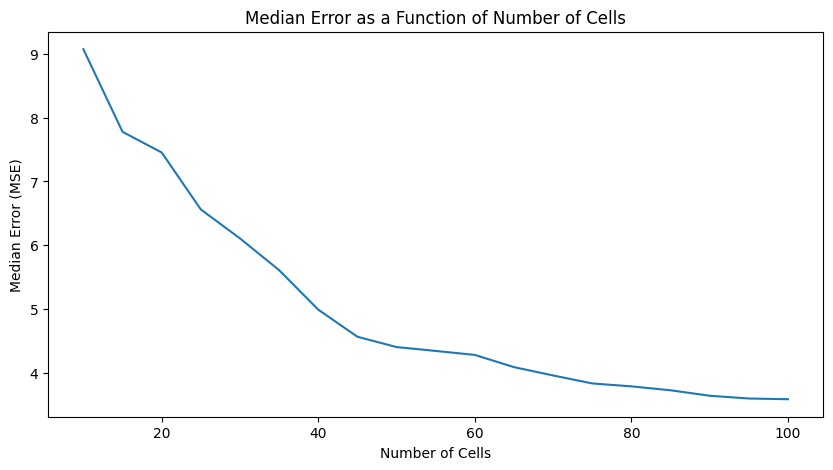

In [ ]:


# Calculate MSE for different sample sizes of cells
nr_cells = np.arange(10, 101, 5)
mse_list = []

for n_cells in nr_cells:
    # Decode the position using n_cells
    x_decoded = decode_position(n_cells, spikes, true_firing_rate_maps, fps, true_x, t)

    # Sample the true and decoded positions


    # Calculate MSE
    mse = np.sqrt((np.array(true_x) - np.array(x_decoded)) ** 2)
    mse_list.append(np.nanmedian(mse))

# Plot the median MSE as a function of the number of cells
plt.plot(nr_cells, mse_list)
plt.xlabel("Number of Cells")
plt.ylabel("Median Error (MSE)")
plt.title("Median Error as a Function of Number of Cells")
plt.show()


As expectes, the more cells the more precise the decoding of the data and hence a smaller MSE

##C)

In [ ]:
avg_firing = np.arange(1, 15, 0.4)
mse_list = []
for avg_fire in avg_firing:
  track_length = 200. # the length of our linear track (eg in centimeter)
  average_firing_rate = avg_fire # the peak firing rate, averaged across the population
  n_cells = 100 # how many cells we are recording
  pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
  pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
  pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

  # GENERATE TRAJECTORY

  n_runs = 10
  use_stops = False
  av_running_speed = 10 # the average running speed (in cm/s)
  fps = 10 # the number of "video frames" per second
  running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
  running_speed_b = np.random.chisquare(10, size=n_runs)

  stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
  stopping_time_b = np.random.chisquare(15, size=n_runs)

  x = np.array([])


  for i in range(n_runs):
      stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
      run_length = len(bins) * fps / running_speed_a[i]
      run1 = np.linspace(0., float(len(bins)-1), int(run_length))
      stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
      run_length = len(bins) * fps / running_speed_b[i]
      run2 = np.linspace(len(bins)-1., 0., int(run_length))
      if use_stops:
          x = np.concatenate((x, stop1, run1, stop2, run2))
      else:
          x = np.concatenate((x, run1, run2))
  t = np.arange(len(x))/fps

  sampling_rate = 10000.
  t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
  x_sampling = np.floor(np.interp(t_sampling, t, x))
  noise_firing_rate = 0.1 # the baseline noise firing rate
  spikes = []

  for i in range(n_cells):
      inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
      spikes_loc = np.random.poisson(inst_rate/sampling_rate)
      sp = np.argwhere(spikes_loc)
      t_sp = t_sampling[sp]
      spikes.append(t_sp)

  file_name = 'linear_track_data.pickle' # change this name when you save new data

  out_data = {}
  out_data['x'] = x
  out_data['t'] = t
  out_data['spikes'] = spikes
  out_data['track_length'] = track_length
  out_data['fps'] = fps

  with open('data/'+file_name,'wb') as f:
      pickle.dump(out_data,f)
  true_x = x[:-1]
  x_decoded = decode_position(n_cells, spikes, true_firing_rate_maps, fps, true_x, t)
  mse = np.sqrt((np.array(true_x) - np.array(x_decoded)) ** 2)
  mse_list.append(np.nanmedian(mse))

100%|██████████| 4876/4876 [00:18<00:00, 270.85it/s]


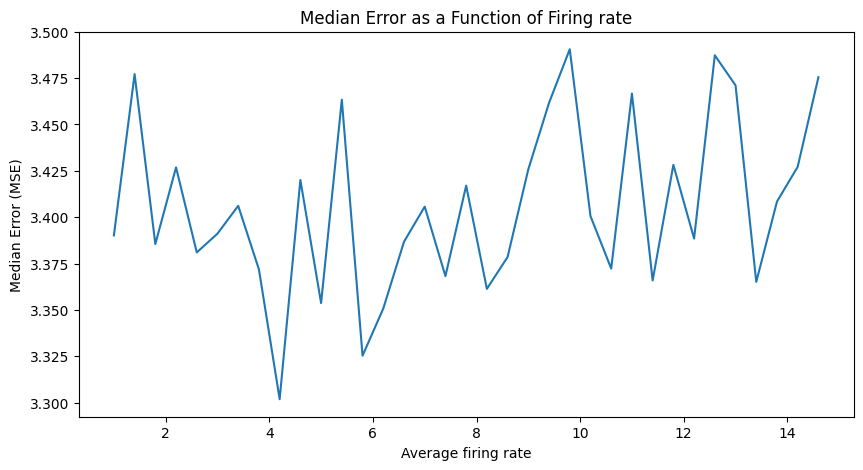

In [ ]:
plt.plot(avg_firing, mse_list)
plt.xlabel("Average firing rate")
plt.ylabel("Median Error (MSE)")
plt.title("Median Error as a Function of Firing rate")
plt.show()

The plot looks rather random and it therefore seems that the firing rate has no significant influence.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$.
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [11]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [12]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [13]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [14]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [17]:
file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [18]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            #posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan

100%|██████████| 4788/4788 [00:26<00:00, 183.56it/s]


Median error: 4.438095238095229 cm


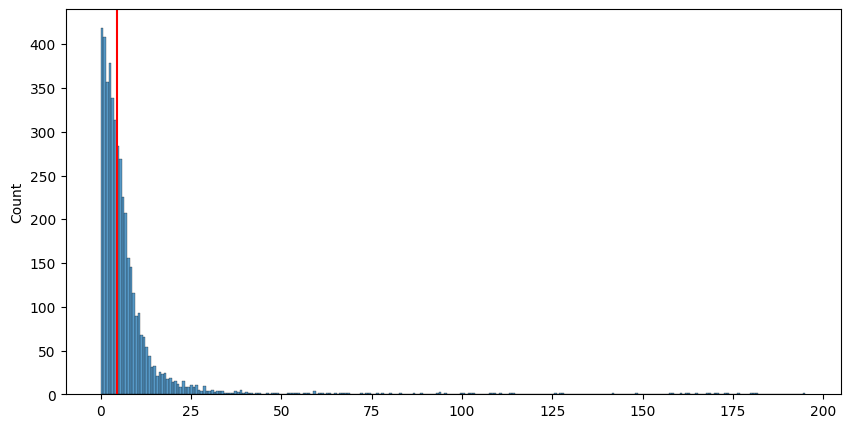

In [ ]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')

My best guess is theat for small probabilities the log becomes unstable. Therefore in some runs it has numerical issues.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


##a)

In [3]:
from scipy.stats import pearsonr

In [19]:
# generate data

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length

    #store reactivation sequence
    reactivation_events[event,:] = x_react


    # Generate spikes according to the location being reactivated in this event

    for i in range(n_cells):# we compute the poistion at which each spike was emitted
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1

In [20]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [22]:
# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


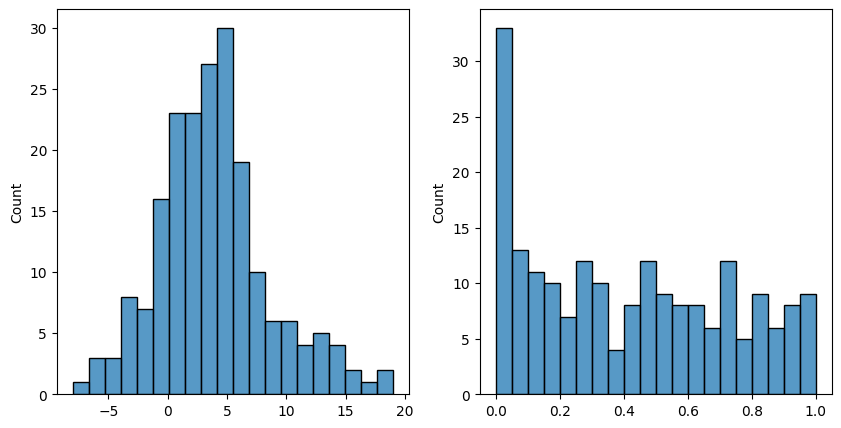

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes,bins=20)
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues,bins=20)
plt.show()

##b)

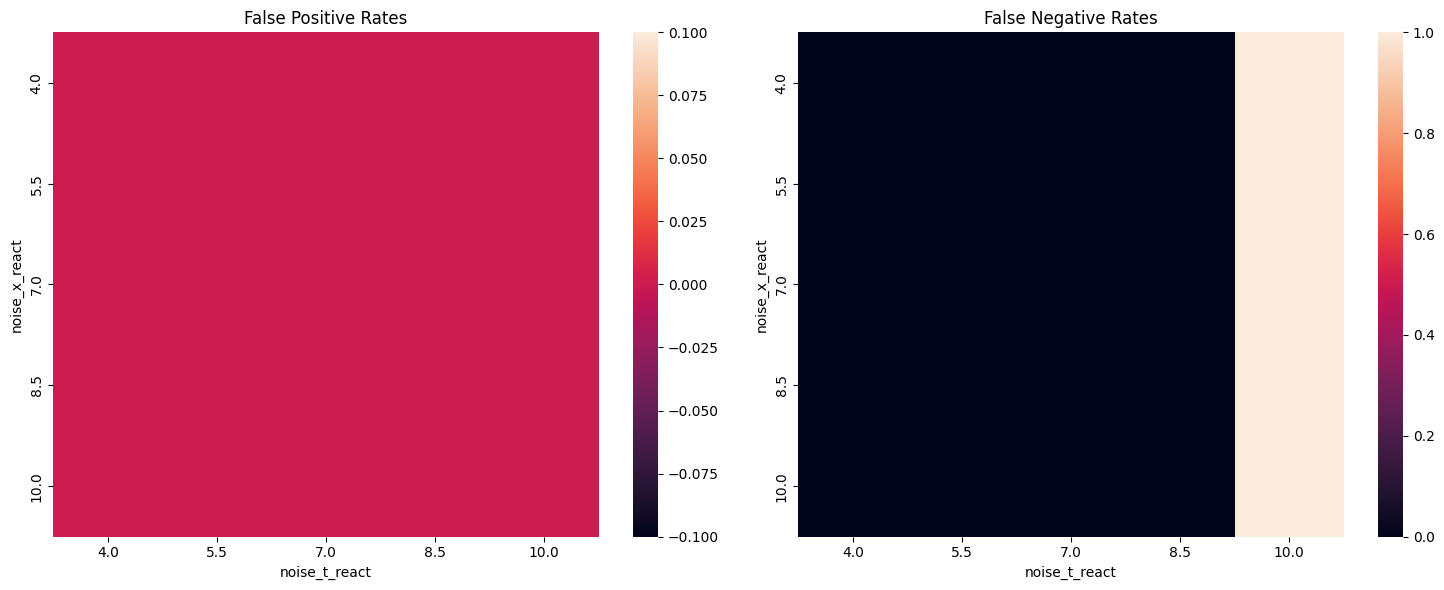

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, pearsonr

# Define ranges for noise parameters
noise_x_react_values = np.linspace(4, 10, 5)  # Example range for noise_x_react
noise_t_react_values = np.linspace(4, 10, 5)  # Example range for noise_t_react

# Containers to store results
false_positive_rates = np.zeros((len(noise_x_react_values), len(noise_t_react_values)))
false_negative_rates = np.zeros((len(noise_x_react_values), len(noise_t_react_values)))

# Loop over noise parameter combinations
for k, noise_x_react in enumerate(noise_x_react_values):
    for j, noise_t_react in enumerate(noise_t_react_values):
        n_events = 200 # number of reactivation events
        event_duration = 100 # in bins
        sampling_rate = 100 # sampling rate
        t_react = np.arange(0,100)
        noise_firing_rate = 0.1 # the baseline noise firing rate


        reactivation_events = np.zeros((n_events,event_duration))
        spikes_react = np.zeros((n_events,n_cells,event_duration))

        for event in range(n_events):
            if(event<=n_events//2):
            #Generate "real" sequences for the first half of events
                x_start = np.random.uniform(0,track_length) # Starting point
                x_end = np.random.uniform(0,track_length) # Ending point
                x_react = np.linspace(x_start,x_end,event_duration) \
                    +np.random.normal(0,noise_x_react,size=event_duration)

            else:
                #Pick locations randomly for the second half
                x_react = np.random.uniform(0,track_length,size=event_duration);

            x_react[x_react<0]=0;
            x_react[x_react>track_length]=track_length

            #store reactivation sequence
            reactivation_events[event,:] = x_react


    # Generate spikes according to the location being reactivated in this event

    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1


        time_window = 10 # number of bins to aggregate during decoding

        reactivation_slope = np.zeros(n_events)

        for event in range(n_events):

            event_spikes = spikes_react[event]
            # First we bin the events in windows of 10 bins
            spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
            # We generate a new spike matrix with the re-sized window
            for t_r in range(1,event_spikes.shape[1]//time_window):
                spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

        # to do: bayesian decoding
        t_resize = 10 # We use spikes from multiple time windows for the decoding

        reactivation_slopes = np.zeros(n_events)
        reactivation_pvalues = np.zeros(n_events)

        for event in range(n_events):

            event_spikes = spikes_react[event]
            spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

            # We generate a new spike matrix with the re-sized window
            for t_r in range(1,event_spikes.shape[1]//t_resize):
                spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


            # We then perform decoding on the aggregated spikes
            x_decoded = np.zeros(spikes_sampled.shape[1])

            for t_bin in range(spikes_sampled.shape[1]):

                if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                    posterior = np.empty(firing_rate_maps.shape[-1])
                    for i in range(len(posterior)):
                        posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                    x_decoded[t_bin] = space_bins[np.argmax(posterior)]

                else:
                    x_decoded[t_bin] = np.nan

                # We fit a line to the decoded positions, and save the slope
                slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
                reactivation_slopes[event] = slope
                # And calculate the pvalue of the pearson correlation
                corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
                reactivation_pvalues[event] = corr[1]
        # Calculate false positives and false negatives
        true_positives = np.sum((reactivation_slopes[:n_events//2] > 0) & (reactivation_pvalues[:n_events//2] < 0.05))
        false_positives = np.sum((reactivation_slopes[n_events//2:] > 0) & (reactivation_pvalues[n_events//2:] < 0.05))
        false_negatives = np.sum((reactivation_slopes[:n_events//2] <= 0) | (reactivation_pvalues[:n_events//2] >= 0.05))

        false_positive_rate = false_positives / (n_events // 2)
        false_negative_rate = false_negatives / (n_events // 2)

        false_positive_rates[k, j] = false_positive_rate
        false_negative_rates[k, j] = false_negative_rate


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(false_positive_rates, xticklabels=noise_t_react_values, yticklabels=noise_x_react_values, ax=ax[0])
ax[0].set_title("False Positive Rates")
ax[0].set_xlabel("noise_t_react")
ax[0].set_ylabel("noise_x_react")

sns.heatmap(false_negative_rates, xticklabels=noise_t_react_values, yticklabels=noise_x_react_values, ax=ax[1])
ax[1].set_title("False Negative Rates")
ax[1].set_xlabel("noise_t_react")
ax[1].set_ylabel("noise_x_react")

plt.tight_layout()
plt.show()


This run forever and didn't quite work out. But I would would guess that increasing the noise of the reactivation will lead to overall more signals and therefore more false positives and negatives.

##c)<br>
The current method detects clear, linear sequences of neural activity with consistent timing, typical of orderly spatial movement. However, it struggles with non-linear sequences, high noise, variable firing rates, temporally distorted sequences, and bidirectional activity. To improve detection, alternative methods like Hidden Markov Models (HMMs), Bayesian Sequential Analysis.